# Introduction

The notebook expands upon the image classification example in notebook `1.1-flowers-in-tensorflow.ipynb`, illustrating some additional ideas and concepts from TensorFlow.

Last time we had a look at an image classification example, we used high-level functionality from Keras to read images from disk. This time we'll use the more efficient TFRecords format to store the images, and show how to work with TFRecords in TensorFlow.

# Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import pickle, PIL, os
from pathlib import Path

In [ ]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
# as that makes some difference for the code below.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

In [ ]:
# Set to True if you're using Paperspace Gradient:
gradient=False

In [ ]:
if colab:
    from google.colab import drive
    drive.mount('./gdrive')
    DATADIR = Path('./gdrive/MyDrive/ColabData')
elif gradient:
    DATADIR = Path('/storage')

else:
    from fastcore.all import *
    NB_DIR = Path.cwd()
    DATADIR = Path('/home/alex/data/dat255')  # Set this to where you want to store downloaded data
    
DATADIR.mkdir(exist_ok=True)

In [1]:
import tensorflow as tf
from tensorflow import keras

# Load the flowers data and store as TFRecords

This is the data set we downloaded in the notebook `0.1-download_flowers_data.ipynb`, and studied in the two notebooks `1.0` (fastai) and `1.1` (TensorFlow).

In [2]:
with open(DATADIR/'path.pkl', 'rb') as f:
    path = pickle.load(f)

In [3]:
list(path.iterdir())

[PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset_train.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset_test.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/roses'),
 PosixPath('/home/alex/data/dat255/flower_photos/LICENSE.txt'),
 PosixPath('/home/alex/data/dat255/flower_photos/dandelion'),
 PosixPath('/home/alex/data/dat255/flower_photos/tulips'),
 PosixPath('/home/alex/data/dat255/flower_photos/sunflowers'),
 PosixPath('/home/alex/data/dat255/flower_photos/daisy')]

**Plot some random images:**

In [4]:
import random

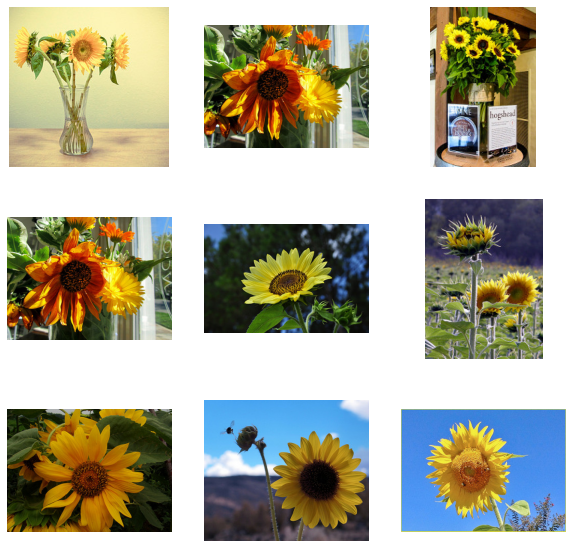

In [5]:
kind = 'sunflowers'
nb = 9
images = random.choices(list((path/kind).iterdir()), k=nb)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(images[i])
    plt.imshow(img)
    plt.axis("off")

## Split images into train and test

In [8]:
all_images = list(path.glob("*/*.jpg"))
nb_images = len(all_images)
nb_images

3670

We shuffle the images to make sure we can get all classes in the test set by slicing the list.

In [10]:
random.shuffle(all_images)

In [12]:
test_size=0.2

In [13]:
train_images = all_images[:int((1-test_size)*nb_images)]

test_images = all_images[int((1-test_size)*nb_images):]

print(f"nb train images: {len(train_images)}\n nb test images: {len(test_images)}")

nb train images: 2936
 nb test images: 734


## Load and store as TFRecord

> TFRecord is a data format for storing sequences of binary records. Performance-wise, binary formats allow for fast reading and writing. TensorFlow has several optimization that are based on TFRecord, allowing for seamless integration with everything from preprocessing layers to distributed data sets. 

https://www.tensorflow.org/tutorials/load_data/tfrecord

We're going to store the images as binary records, using TFRecord. For this, we need to specify the structure of the data, including the labels we want to assign to each image. 

### Get labels

In [14]:
sorted(list(path.iterdir()))

[PosixPath('/home/alex/data/dat255/flower_photos/LICENSE.txt'),
 PosixPath('/home/alex/data/dat255/flower_photos/daisy'),
 PosixPath('/home/alex/data/dat255/flower_photos/dandelion'),
 PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset_test.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/flowers_dataset_train.tfrecord'),
 PosixPath('/home/alex/data/dat255/flower_photos/roses'),
 PosixPath('/home/alex/data/dat255/flower_photos/sunflowers'),
 PosixPath('/home/alex/data/dat255/flower_photos/tulips')]

In [15]:
labels_dict = {0: 'daisy',
               1: 'dandelion',
               2: 'roses',
               3: 'sunflowers',
               4: 'tulips'}

In [16]:
labels_dict_reversed = {v: k for k,v in labels_dict.items()}

In [17]:
labels_dict_reversed

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [19]:
def get_label(img_path):
    label = img_path.parent.stem
    return labels_dict_reversed[label]

**Test**

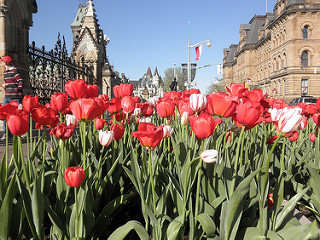

In [20]:
test_img_path = train_images[10]
test_img = PIL.Image.open(test_img_path)
test_img

In [21]:
get_label(test_img_path)

4

In [22]:
labels_dict[get_label(test_img_path)]

'tulips'

### Save the raw image data as byte strings in a tensor

In [23]:
test_img_tensor = tf.io.read_file(str(test_img_path))

2022-03-23 12:25:38.775862: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 12:25:39.610947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30510 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0


In [24]:
len(test_img_tensor.numpy())

53323

In [25]:
test_img_tensor.numpy()[:50]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06'

### Construct `tf.train.Example`

To specify the structure of the data stored as byte strings, we can use `tf.train.Example`, a standard [protocol buffer](https://developers.google.com/protocol-buffers/docs/overview) for serializing data (created by Google). 

https://www.tensorflow.org/tutorials/load_data/tfrecord#tftrainexample

In [26]:
#?tf.train.Example

In [27]:
#?tf.train.Feature

Helper functions to turn scalar values into `tf.train.Feature`s containing BytesLists or Int64Lists. These can then be used as features in a `tf.train.Example` (which is a mapping `{"string": tf.train.Feature}`).

In [28]:
# Helper functions taken from 
# https://www.tensorflow.org/tutorials/load_data/tfrecord#tftrainexample

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

**Test:**

In [29]:
test_example = tf.train.Example(features=tf.train.Features(
    feature = {'image_raw': _bytes_feature(test_img_tensor.numpy()), 
               'label': _int64_feature(get_label(test_img_path))}
))

In [31]:
#test_example

### Write all images to tfrecord

In [32]:
tfrecord_train_fn = str(path/'flowers_dataset_train.tfrecord')
tfrecord_test_fn = str(path/'flowers_dataset_test.tfrecord')

In [33]:
def write_tfrecord(images, tfrecord_fn):
    if not os.path.isfile(tfrecord_fn):
        with tf.io.TFRecordWriter(tfrecord_fn) as writer:
            for img_path in images:
                try:
                    raw_file = tf.io.read_file(str(img_path))
                except:
                    print(f"File {img_path} could not be read")
                    continue

                example = tf.train.Example(features=tf.train.Features(
                            feature = {'image_raw': _bytes_feature(raw_file.numpy()), 
                                       'label': _int64_feature(get_label(img_path))}
        ))
                writer.write(example.SerializeToString())
                
            print(f"TFRecord written to {tfrecord_fn}")

    else:
        print(f"TFRecords already written to disk: {tfrecord_fn}")
        return

In [34]:
write_tfrecord(train_images, tfrecord_train_fn)

TFRecords already written to disk: /home/alex/data/dat255/flower_photos/flowers_dataset_train.tfrecord


In [35]:
write_tfrecord(test_images, tfrecord_test_fn)

TFRecords already written to disk: /home/alex/data/dat255/flower_photos/flowers_dataset_test.tfrecord


# Dataloader

We can now construct data sets and dataloaders that gets data from the stored TFRecords. For this, we use the `tf.data` API: https://www.tensorflow.org/guide/data_performance. We'll partly follow the example from https://keras.io/examples/keras_recipes/tfrecord/. Have a look at this example for some additional details and links.

In [36]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

We need to decode the byte strings representing JPEG images:

In [37]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return image

In [38]:
def read_tfrecord(example):
    tfrecord_format = {
            "image_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64)

    }
    
    example = tf.io.parse_single_example(example, tfrecord_format)

    
    image = decode_image(example["image_raw"])
    label = tf.cast(example["label"], tf.int32)
    return image, label

We construct data sets by shuffling, prefetching and batching the data read from TFRecords:

In [39]:
def load_dataset(fn):
    dataset = tf.data.TFRecordDataset(fn)
    
    dataset = dataset.map(read_tfrecord, num_parallel_calls=8)
    
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=64)
    
    
    return dataset

In [40]:
train_dataset = load_dataset(tfrecord_train_fn)
test_dataset = load_dataset(tfrecord_test_fn)

**Plot some images:**

As you are very well aware of by now, it's always a good idea to have a look at the data after each step. Here's a few images from the batches extracted from the training and test datasets:

In [41]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(labels_dict[label_batch[n]])
        plt.axis("off")

In [42]:
image_batch, label_batch = next(iter(train_dataset))

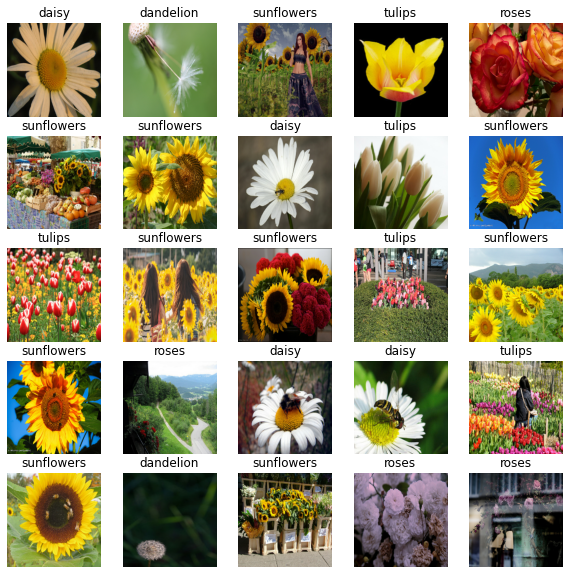

In [43]:
show_batch(image_batch.numpy(), label_batch.numpy())

From the test set:

In [44]:
image_batch, label_batch = next(iter(test_dataset))

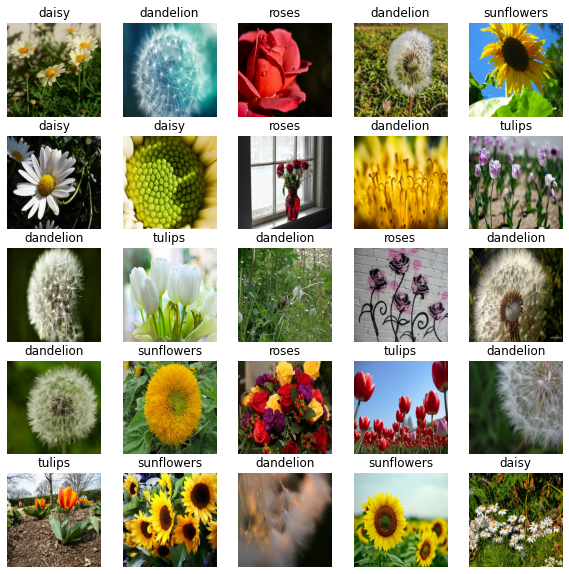

In [45]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Train a model

Now we can train a model. We'll follow the setup in notebook `1.1`, with some minor modifications.

This time we'll try out a learning rate schedule:

In [46]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

We'll set up two different base models: an Xception model and a ResNet50

In [47]:
base_model_xc = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

preprocess_input_xc = keras.applications.xception.preprocess_input

In [48]:
base_model_rn = keras.applications.resnet.ResNet50(
         input_shape=(*IMAGE_SIZE,3), include_top=False, weights="imagenet")

preprocess_input_rn = keras.applications.resnet.preprocess_input

The below model is essentially a copy of the one in notebook `1.1`. Consult that notebook for additional details. 

In [49]:
def make_model(base_model, preprocess_input):
    
    base_model.trainable = False

    inputs = keras.layers.Input([*IMAGE_SIZE, 3])
    
    # Data augmentation
    x = keras.layers.Resizing(224, 224)(inputs)
    x = keras.layers.RandomFlip("horizontal")(x)
    x = keras.layers.RandomRotation(0.1)(x)
    x = keras.layers.RandomZoom(0.1)(x)
    x = keras.layers.RandomContrast(factor=0.01)(x) 
    
    # Preprocess according to the base model
    x = preprocess_input(x)
    
    # Pass through the base model
    x = base_model(x)
    
    # Head
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Dropout(rate=0.5)(x)

    outputs = keras.layers.Dense(5, activation="softmax")(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics="accuracy",
    )

    return model

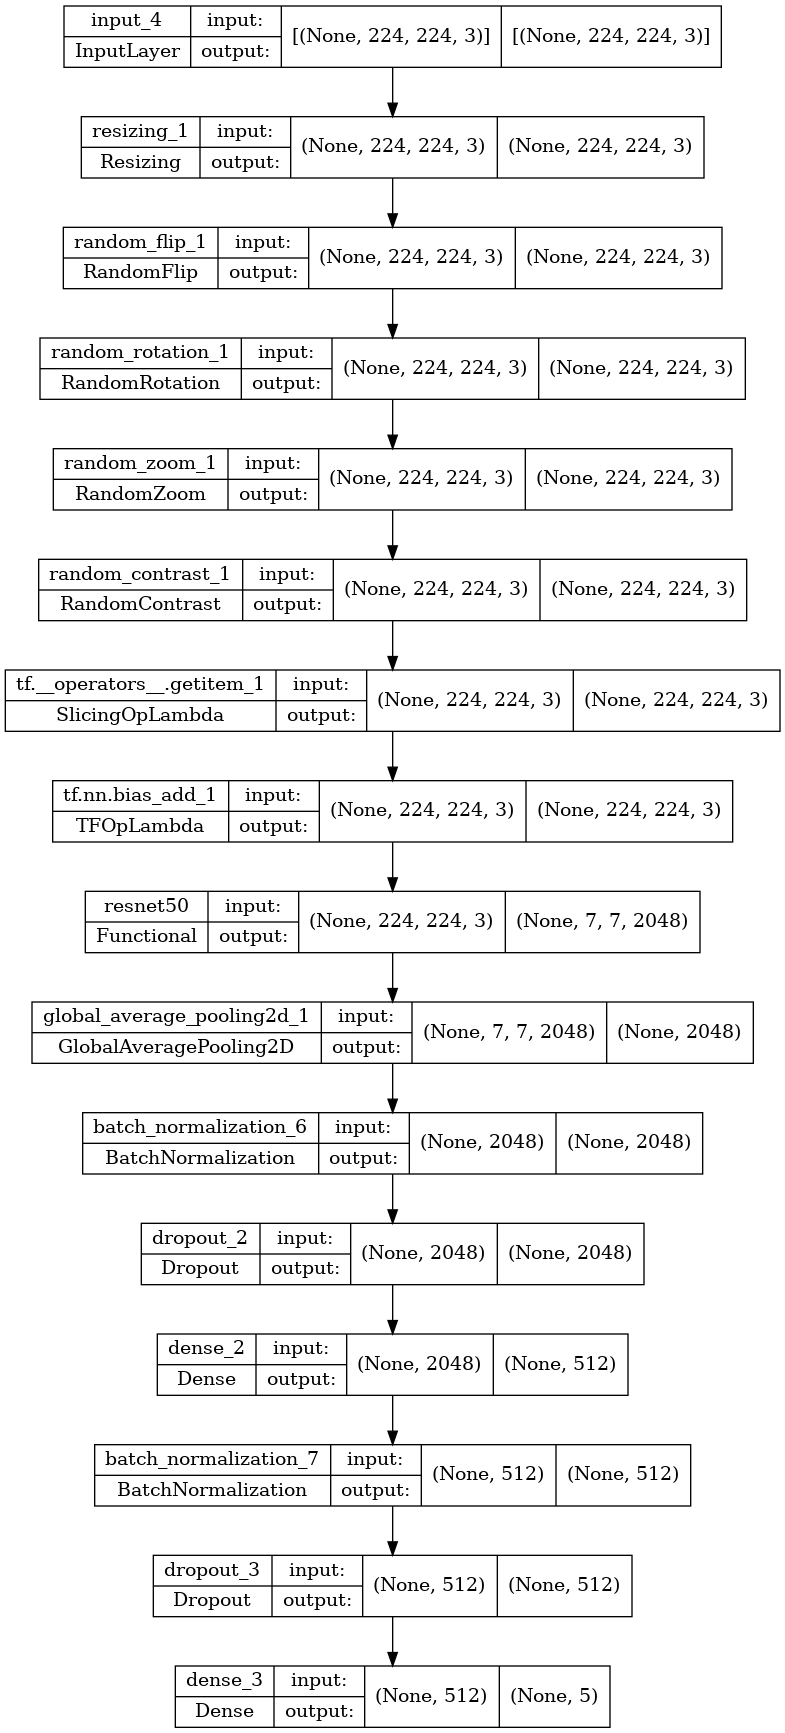

In [51]:
model = make_model(base_model=base_model_rn, preprocess_input=preprocess_input_rn)
tf.keras.utils.plot_model(model, show_shapes=True)

Let's train it. We'll add a TensorBoard callback. More on that below.

In [52]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [53]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

Epoch 1/3


2022-03-23 12:40:51.963066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-23 12:40:52.754151: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 12:40:52.754871: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 12:40:52.754918: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-23 12:40:52.755527: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 12:40:52.755659: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


46/46 [==============================] - 15s 169ms/step - loss: 0.8470 - accuracy: 0.7813 - val_loss: 0.4439 - val_accuracy: 0.8747
Epoch 2/3
46/46 [==============================] - 5s 107ms/step - loss: 0.3983 - accuracy: 0.8716 - val_loss: 0.3761 - val_accuracy: 0.8978
Epoch 3/3
46/46 [==============================] - 6s 115ms/step - loss: 0.3447 - accuracy: 0.8927 - val_loss: 0.3218 - val_accuracy: 0.9033


### Tensorboard

It's useful to follow along with the training process, visualize and inspect the trained model using TensorBoard: 

In [54]:
%load_ext tensorboard

In [55]:
%tensorboard --logdir logs

See here for an illustration of TensorBoard: https://www.tensorflow.org/tensorboard/images/tensorboard.gif.

# Evaluate

Now we can evaluate the model in all the ways discussed previously. Here we simply compute the accuract on the validation data plot some predictions. 

In [56]:
loss, acc = model.evaluate(test_dataset)

12/12 [==============================] - 1s 69ms/step - loss: 0.3218 - accuracy: 0.9033


In [57]:
print(f"Loss: {loss}\n Accuracy: {acc}")

Loss: 0.3218131363391876
 Accuracy: 0.9032697677612305


In [58]:
def show_batch_predictions(image_batch, label_batch):
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("prediction / actual", y=0.93)
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        img_array = tf.expand_dims(image_batch[n], axis=0)
        title = f"{labels_dict[model.predict(img_array)[0].argmax()]}/ {labels_dict[label_batch.numpy()[n]]}"
        plt.title(title, fontsize=10)
        plt.axis("off")

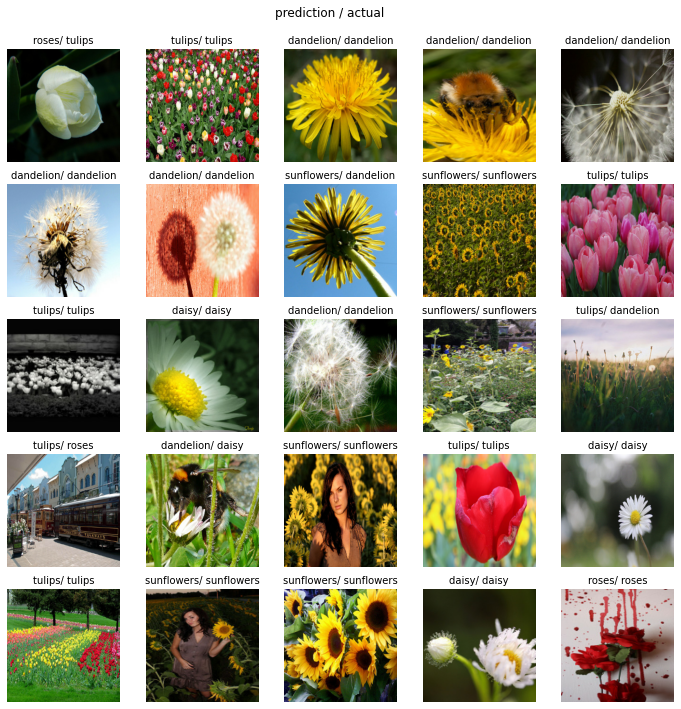

In [59]:
image_batch, label_batch = next(iter(test_dataset))

show_batch_predictions(image_batch, label_batch)